In [53]:
import pickle
import os
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, roc_auc_score


In [54]:
model_pathLRGPT35 = '../model/pickle_Crossvalidation/LogisticRegression/gpt35_model.pkl'
model_pathRFGPT35 = '../model/pickle_Crossvalidation/RandomForest/gpt35_model.pkl'
model_pathSVMGPT35 = '../model/pickle_Crossvalidation/LogisticRegression/gpt35_model.pkl'

model_pathLRNeo = '../model/pickle_Crossvalidation/LogisticRegression/gptNeo_model.pkl'
model_pathRFNeo = '../model/pickle_Crossvalidation/RandomForest/gptNeo_model.pkl'
model_pathSVMNeo = '../model/pickle_Crossvalidation/LogisticRegression/gptNeo_model.pkl'

model_pathLRMistral = '../model/pickle_Crossvalidation/LogisticRegression/mistral_model.pkl'
model_pathRFMistral = '../model/pickle_Crossvalidation/RandomForest/mistral_model.pkl'
model_pathSVMMistral = '../model/pickle_Crossvalidation/LogisticRegression/mistral_model.pkl'

In [55]:
data = pd.read_csv('../../../preprocessing/StorePreprocessed/Llama3csv.csv')

data = data.dropna(subset=["text", "label"])

X = data["text"]
y = data["label"]

vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(4, 4), max_features=11000)

X_test = vectorizer.fit_transform(X)
y_test = y

In [56]:
if os.path.exists(model_pathLRGPT35) and os.path.exists(model_pathRFGPT35) and os.path.exists(model_pathSVMGPT35):
    with open(model_pathLRGPT35, 'rb') as lr:
        lr_bestGPT35 = pickle.load(lr)
    with open(model_pathRFGPT35, 'rb') as rf:
        rf_bestGPT35 = pickle.load(rf)
    with open(model_pathSVMGPT35, 'rb') as svm:
        svm_bestGPT35 = pickle.load(svm)
else:
    print('Model Neo not found')
    exit(1)

if os.path.exists(model_pathLRNeo) and os.path.exists(model_pathRFNeo) and os.path.exists(model_pathSVMNeo):
    with open(model_pathLRNeo, 'rb') as lr:
        lr_bestNeo = pickle.load(lr)
    with open(model_pathRFNeo, 'rb') as rf:
        rf_bestNeo = pickle.load(rf)
    with open(model_pathSVMNeo, 'rb') as svm:
        svm_bestNeo = pickle.load(svm)
else:
    print('Model Neo not found')
    exit(1)

if os.path.exists(model_pathLRMistral) and os.path.exists(model_pathRFMistral) and os.path.exists(model_pathSVMMistral):
    with open(model_pathLRMistral, 'rb') as lr:
        lr_bestMistral = pickle.load(lr)
    with open(model_pathRFMistral, 'rb') as rf:
        rf_bestMistral = pickle.load(rf)
    with open(model_pathSVMMistral, 'rb') as svm:
        svm_bestMistral = pickle.load(svm)
else:
    print('Model Llama3 not found')
    exit(1)

In [57]:
y_pred_lrGPT35 = lr_bestGPT35.predict(X_test)
y_pred_rfGPT35 = rf_bestGPT35.predict(X_test)
y_pred_svmGPT35 = svm_bestGPT35.predict(X_test)

y_pred_lrNeo = lr_bestNeo.predict(X_test)
y_pred_rfNeo = rf_bestNeo.predict(X_test)
y_pred_svmNeo = svm_bestNeo.predict(X_test)

y_pred_lrMistral = lr_bestMistral.predict(X_test)
y_pred_rfMistral = rf_bestMistral.predict(X_test)
y_pred_svmMistral = svm_bestMistral.predict(X_test)

In [58]:
# Mayority Voting
predictionsGPT = np.array([y_pred_lrGPT35, y_pred_rfGPT35, y_pred_svmGPT35])
y_pred_combinedGPT = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predictionsGPT)

predictionsNeo = np.array([y_pred_lrNeo, y_pred_rfNeo, y_pred_svmNeo])
y_pred_combinedNeo = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predictionsNeo)

predictionsMistral = np.array([y_pred_lrMistral, y_pred_rfMistral, y_pred_svmMistral])
y_pred_combinedMistral = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predictionsMistral)

# ultimative Mayority Voting
predictionsEnsemble = np.array([y_pred_combinedGPT, y_pred_combinedNeo, y_pred_combinedMistral])
y_pred_combinedEnsemble = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predictionsEnsemble)

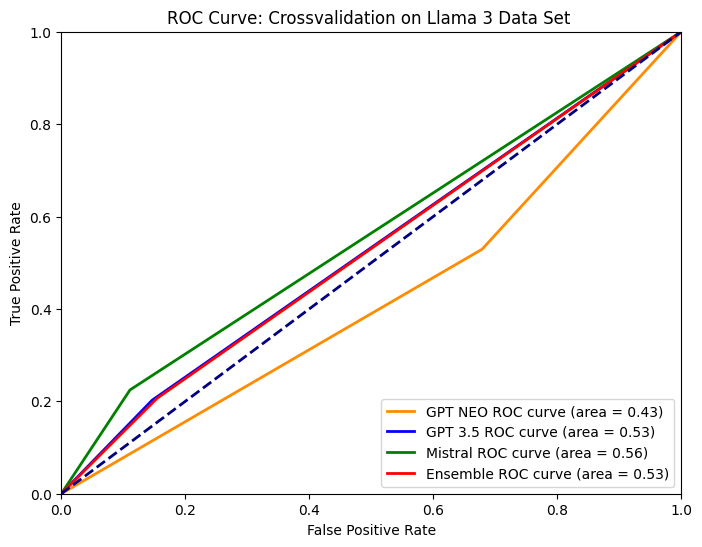

In [59]:
# Calculate ROC and AUC for Neo
fprNeo, tprNeo, thresholdsNeo = roc_curve(y_test, y_pred_combinedNeo)
roc_auc_neo = roc_auc_score(y_test, y_pred_combinedNeo)

# Calculate ROC and AUC for Llama
fprGPT, tprGPT, thresholdsGPT = roc_curve(y_test, y_pred_combinedGPT)
roc_auc_GPT = roc_auc_score(y_test, y_pred_combinedGPT)

# Calculate ROC and AUC for Mistral
fprMistral, tprMistral, thresholdsMistral = roc_curve(y_test, y_pred_combinedMistral)
roc_auc_mistral = roc_auc_score(y_test, y_pred_combinedMistral)

# Calculate ROC and AUC for Ensemble
fprEnsemble, tprEnsemble, thresholdsEnsemble = roc_curve(y_test, y_pred_combinedEnsemble)
roc_auc_Ensemble = roc_auc_score(y_test, y_pred_combinedEnsemble)

plt.figure(figsize=(8, 6))

plt.plot(fprNeo, tprNeo, color='darkorange', lw=2, label=f'GPT NEO ROC curve (area = {roc_auc_neo:.2f})')
plt.plot(fprGPT, tprGPT, color='blue', lw=2, label=f'GPT 3.5 ROC curve (area = {roc_auc_GPT:.2f})')
plt.plot(fprMistral, tprMistral, color='green', lw=2, label=f'Mistral ROC curve (area = {roc_auc_mistral:.2f})')
plt.plot(fprEnsemble, tprEnsemble, color='red', lw=2, label=f'Ensemble ROC curve (area = {roc_auc_Ensemble:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Crossvalidation on Llama 3 Data Set ')
plt.legend(loc='lower right')
plt.savefig('../../../evaluation/Cross-Validation/ROC_Curve_onLlama.png')
plt.show()

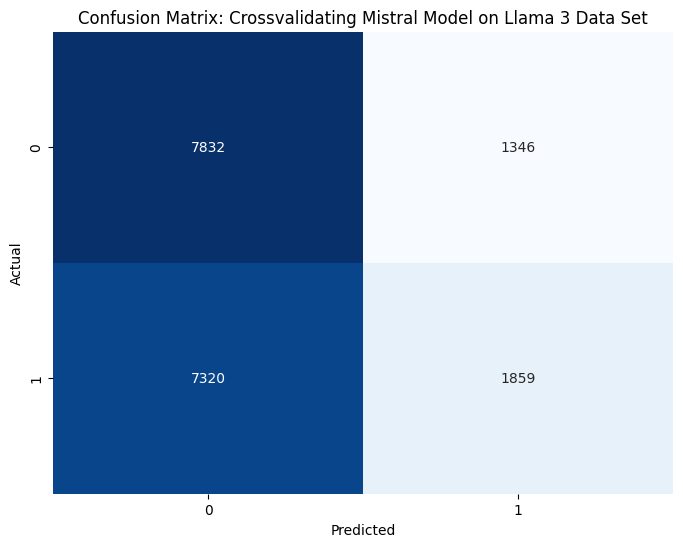

In [60]:
#confusion matrix

cm = confusion_matrix(y_test, y_pred_combinedGPT)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix: Crossvalidating Mistral Model on Llama 3 Data Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('../../../evaluation/Cross-Validation/Confusion_Matrix_LlamaMistral_Cross-Validation.png')
plt.show()

In [61]:
print("Combined Model Classification Report:\n", classification_report(y_test, y_pred_combinedMistral))
print("Combined Model Accuracy:", accuracy_score(y_test, y_pred_combinedMistral))

Combined Model Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.89      0.67      9178
           1       0.67      0.22      0.34      9179

    accuracy                           0.56     18357
   macro avg       0.60      0.56      0.50     18357
weighted avg       0.60      0.56      0.50     18357

Combined Model Accuracy: 0.556899275480743
